In [1]:
from IPython.display import display, Math,Markdown, Audio

In [2]:
from utils import *

In [3]:
EPS=1e-8

In [4]:
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams["figure.facecolor"] = "white"

In [5]:
def cardanoSolve(a,b,c,d):
    A = (c-b**2/3/a)/a
    B=(b*c/3/a-2*b**3/27/a**2-d)/a
    S3 = (B+(B**2+4*A**3/27)**(1/2))/2
    S = S3**(1/3)*np.array([1,np.exp(2j*np.pi/3),np.exp(4j*np.pi/3)])
    x = -b/3/a + S - A/3/S
    return x

In [6]:
def poly4(a,b,c,d):
    return lambda x: a*x**3+b*x**2+c*x+d

In [7]:
def polyOmega(g0,ka,b,o0):
    return poly4(1,-(ka+1j*b),g0*ka+o0**2+1j*b*ka,-ka*o0**2)

In [8]:
def rootsPolyOmega(g0,ka,b,o0):
    return cardanoSolve(1,-(ka+1j*b),g0*ka+o0**2+1j*b*ka,-ka*o0**2)

In [9]:
def SNRestimate(array):
    return abs(np.mean(array))/np.std(array)

In [10]:
pool = Pool(4)

In [79]:
g0_hat=100
o0_hat=10
g0 = 100
ka = g0 /g0_hat;
o0 = ka * o0_hat
b = 0.01

In [80]:
R,S,H,_ = get_RSH_harmonic_onlyka(o0,g0,b,ka)
SNR_omega = abs(H)/np.sqrt(R*S-H)
roots = rootsPolyOmega(g0,ka,b,o0)+EPS+EPS*1j
print(f"omega: {H/R:0.6f}")
# print(f"{alpha:0.4f}, {beta**2:0.4f}")
print(f"relaxation freq:  ",(np.real(roots)).round(2))
print(f"rotational freq:",(np.imag(roots)).round(2))
print(f"SNR: {SNR_omega:0.4f}")

omega: -0.009901
relaxation freq:   [0.5  0.25 0.25]
rotational freq: [ -0.    14.14 -14.13]
SNR: 0.0007


In [81]:
print(f"g0_hat: {g0/ka:0.3f}  o0_hat: {o0/ka:0.3f}")
display(Markdown(f"b:{b:0.1f}  $\gamma$:{g0:0.1f}  $\kappa$:{ka:0.1f}  $\omega_0$:{o0:0.1f}    "\
f"$2\pi/\langle \omega \\rangle$:{2*np.pi/(H/R+EPS):0.3f}s "\
f"SNR (expected):{SNR_omega:0.3f}  <br>"\
f"root1    relaxation: {1/np.real(roots[0]):0.3f}s     rotation: {1/np.imag(roots[0]):0.3f}s <br>"
f"root2    relaxation: {1/np.real(roots[1]):0.3f}s     rotation: {1/np.imag(roots[1]):0.3f}s <br>"
f"root3    relaxation: {1/np.real(roots[2]):0.3f}s     rotation: {1/np.imag(roots[2]):0.3f}s "))

g0_hat: 100.000  o0_hat: 10.000


b:0.0  $\gamma$:100.0  $\kappa$:1.0  $\omega_0$:10.0    $2\pi/\langle \omega \rangle$:-634.602s SNR (expected):0.001  <br>root1    relaxation: 1.997s     rotation: -79964.268s <br>root2    relaxation: 4.006s     rotation: 0.071s <br>root3    relaxation: 4.004s     rotation: -0.071s 

In [82]:
N=3000000
warmup=N//2
dt=0.0001
samples=10
skip=1
runs=4
time = np.linspace(0,N//skip *dt, N//skip)

print(f"memory {(len([1]) * N * runs * samples *4 // skip) * 4 / 1024**3:0.2f}")

memory 1.79


In [83]:
sigma = get_cov(np.array([R]), np.array([S]), np.array([H]))

x0,y0,vx0,vy0 = np.random.multivariate_normal(
    [0,0,0,0], 0*sigma[...,0], samples).T
kwargs = dict(x0=x0,y0=y0,vx0=vx0,vy0=vy0,
    N=N, samples=samples,
    dt=dt, warmup=warmup, skip=skip,
    omega0=o0,
    gamma0=g0,b=b, kappa=ka)
result = simulate_2d_only_memory(pool,runs,**kwargs)

result = np.array(result); result.shape


(6, 40, 3000000)

In [84]:
x,y,vx,vy,_,_ = result

In [85]:
crosprod=(-x[:,1:]*y[:,:-1] + y[:,1:]*x[:,:-1])/(np.sqrt(x[:,1:]**2+y[:,1:]**2)*np.sqrt(x[:,:-1]**2+y[:,:-1]**2))
phi = np.arcsin(crosprod).cumsum(axis=-1)
del crosprod

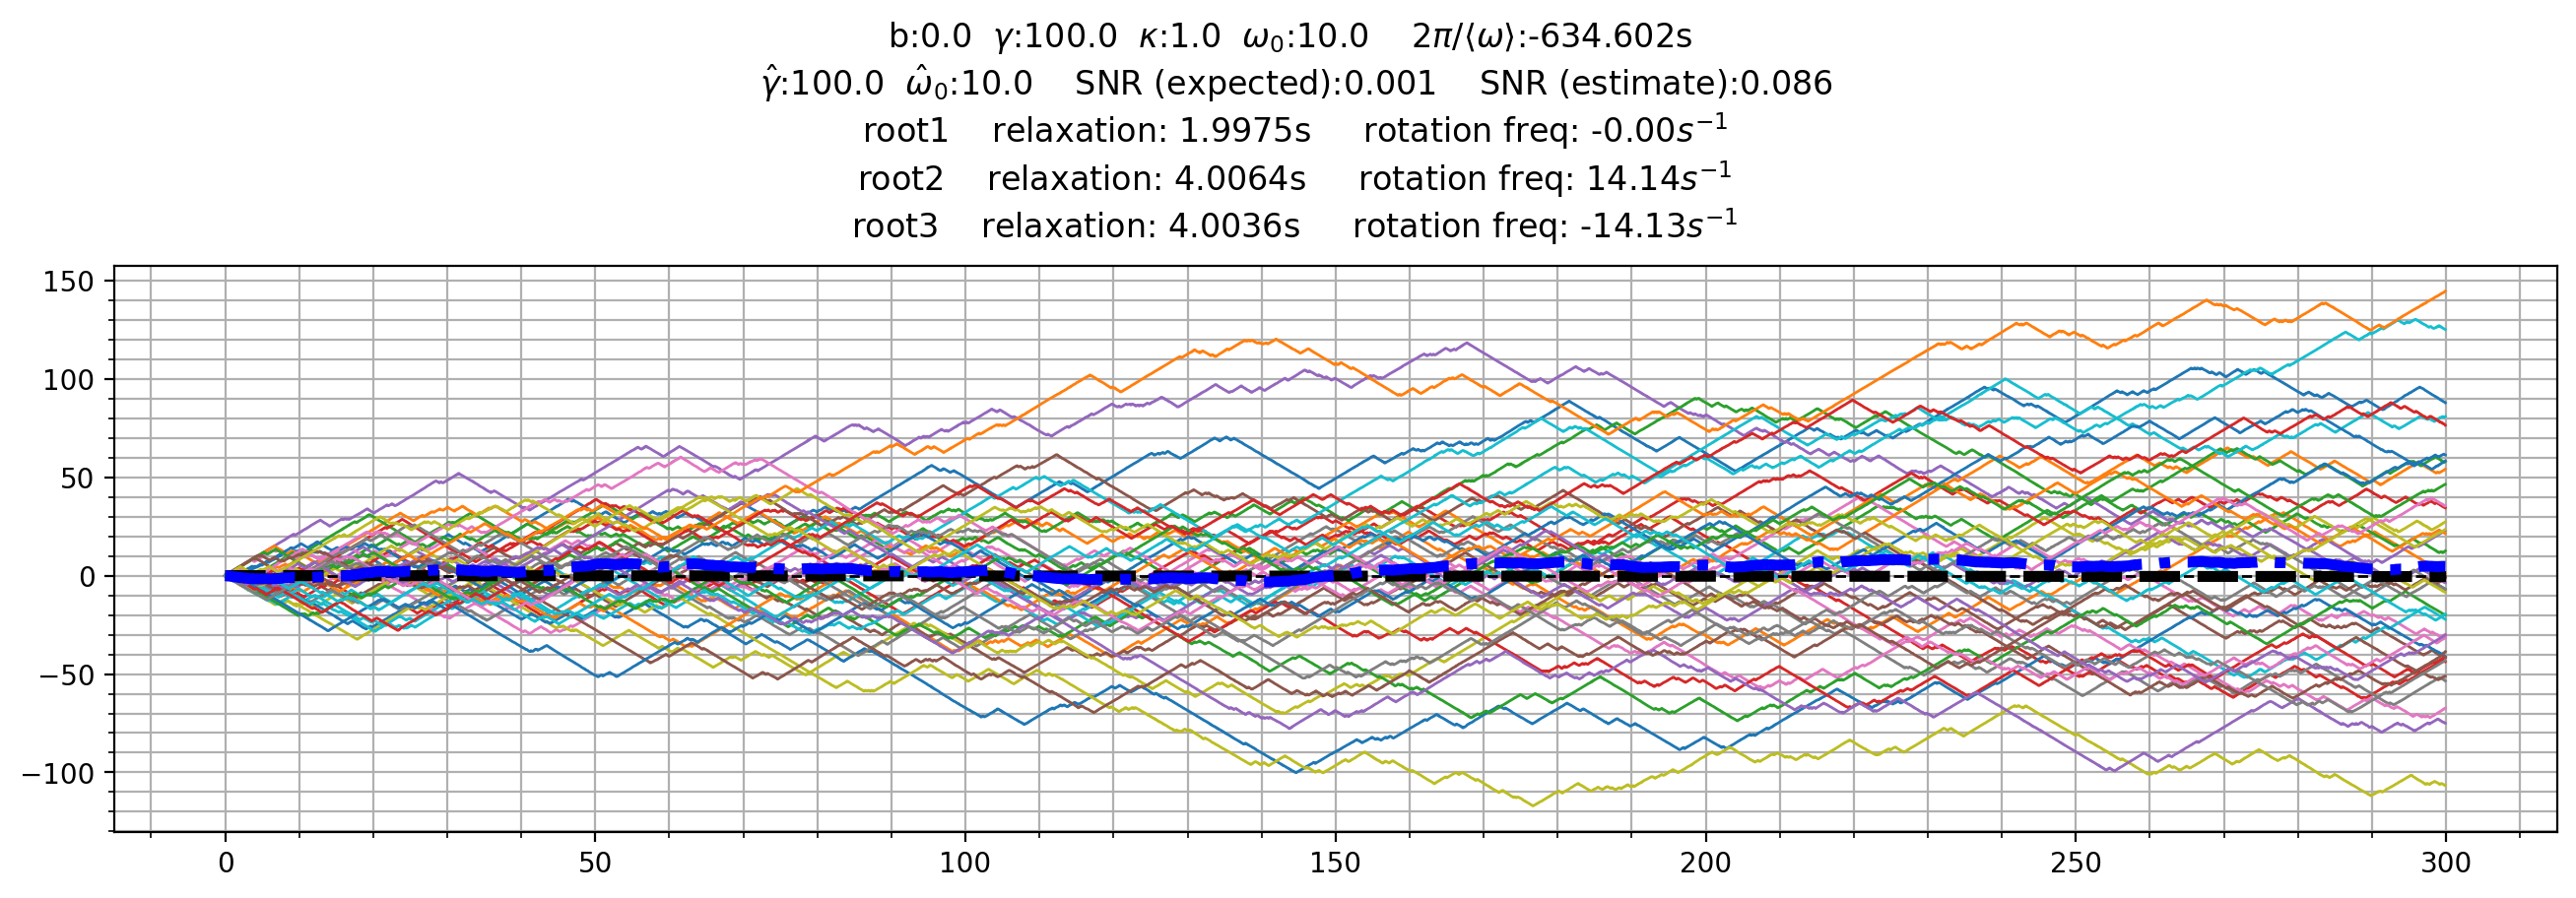

In [86]:
fig = plt.figure(figsize=(16,25), dpi=200)
fig.subplots_adjust(top=0.93)
persec="$s^{-1}$"
plt.suptitle(f"b:{b:0.1f}  $\gamma$:{g0:0.1f}  $\kappa$:{ka:0.1f}  $\omega_0$:{o0:0.1f}    "\
f"$2\pi/\langle \omega \\rangle$:{2*np.pi/(H/R+EPS):0.3f}s  \n"\
f"$\hat\gamma$:{g0/ka}  $\hat\omega_0$:{o0/ka}    "
f"SNR (expected):{SNR_omega:0.3f}    SNR (estimate):{SNRestimate(phi[:,-1]):0.3f}\n"\
f"root1    relaxation: {1/np.real(roots[0]):0.4f}s     rotation freq: {np.imag(roots[0]):0.2f}{persec} \n"
f"root2    relaxation: {1/np.real(roots[1]):0.4f}s     rotation freq: {np.imag(roots[1]):0.2f}{persec} \n"
f"root3    relaxation: {1/np.real(roots[2]):0.4f}s     rotation freq: {np.imag(roots[2]):0.2f}{persec} ")

plt.subplot(6,1,1)
plt.plot(time[::1000,None],phi[:,::1000].T/2/np.pi,lw=1);
plt.plot([0, time[-1]], [0,time[-1]*H/R/2/np.pi], c="k", ls="--", lw=4)
plt.plot([0, time[-1]], [0,0], c="k", ls="--", lw=1)

plt.plot(time[::1000],phi[:,::1000].mean(axis=0)/2/np.pi, lw=4, c="b", ls="-.");
plt.grid(which="both")
plt.minorticks_on()
plt.savefig(f"figs/g-{g0/ka:0.3f},o-{o0/ka:0.3f}.png")


In [87]:
Audio(url='http://www.soundjay.com/button/beep-07.wav', autoplay=True)

### Checkstationarity